# Reproducing figures from paper

This notebook reproduces the main figures from the paper "Efficient Probabilistic Tensor Networks". It provides code and data to generate the profiling, memory, latency, and instability plots for LSF, SGD, and DMRG methods.

## Figure 1: Profiling LSF, SGD & DMRG

#### Memory, Latency & Instability

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Latency:
# >> python scripts/profile_latency.py --horizons 128 --models mps_dmrg_bm mps_lsf_sigma --device cpu
#     latency           name   R    H  Do  Di   B sweep_type  sweep_value                                                                                                                                          
# 0  1.208001    mps_dmrg_bm  32  128   2   1  32          H          128
# 1  0.161665  mps_lsf_sigma  32  128   2   1  32          H          128

# Memory:
# >> python scripts/profile_memory.py --d_outputs 1024 --models mps_dmrg_bm mps_lsf_sigma
#             model     d      mem_mb
# 0     mps_dmrg_bm  1024  217.106445
# 1   mps_lsf_sigma  1024    8.503418

# Instability:
# >> python scripts/profile_instability.py
#             name  horizon  iters
# 0  mps_lsf_sigma      100  10000
# 1  mps_sgd_sigma      100      1
sns.set_theme()

instability_fn = lambda N: 10000 - N + 0.1

# Data
df_latency_mem = pd.DataFrame({
    "Method": ["LSF (ours)", "SGD", "DMRG"],
    "Latency (s)": [0.16, 0.16, 1.2], # SGD and LSF have same latency
    "Memory (MB)": [8.5, 8.5, 217],
    "Instability": [instability_fn(10000), instability_fn(1), instability_fn(10000)],
})

# Melt the dataframe for easier plotting with seaborn
df_melted = df_latency_mem.melt(id_vars="Method", var_name="Metric", value_name="Value")

plt.figure(figsize=(5, 4))  # smaller width
sns.barplot(
    data=df_melted,
    x="Metric",
    y="Value",
    hue="Method",
    width=0.4 
)
plt.yscale("log")
ax = plt.gca()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

## Figure 3: Stability analysis (Part I)

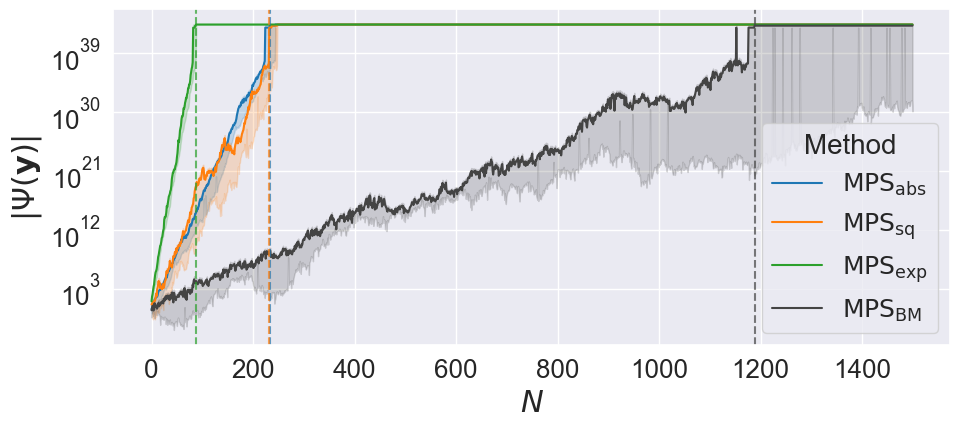

In [39]:
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from collections import OrderedDict

torch.manual_seed(42); np.random.seed(42)

EXPS = [
    (r"$\mathrm{MPS}_\mathrm{abs}$",     lambda W: W.abs(), lambda py: py),
    (r"$\mathrm{MPS}_\mathrm{sq}$",       lambda W: W.square(), lambda py: py),
    (r"$\mathrm{MPS}_\mathrm{exp}$",  lambda W: W.exp(), lambda py: py),
    (r"$\mathrm{MPS}_\mathrm{BM}$",         lambda W: W, lambda py: py),  # special case
]

T, D = 1500, 2
rows, inf_at = [], {}

for seed in [0, 42, 84]:
    for name, fn, py_fn in EXPS:
        alpha, beta, hit = fn(torch.randn(D)), fn(torch.randn(D)), False
        for t in range(T):
            if not hit:
                beta = torch.mv(fn(torch.randn(D, D)), beta)
                hit = not torch.isfinite(beta).all()
                if hit: inf_at[name] = t
            psi = float("inf") if hit else float(py_fn(torch.dot(alpha, beta)))
            rows.append({"Step": t, "Method": name, "psi": abs(psi)})

df = pd.DataFrame(rows)
finite = df[np.isfinite(df["psi"])]["psi"]
cap = (finite.max() if not finite.empty else 1.0) * 1e5
df["psi"] = df["psi"].replace([np.inf], cap)

# Build custom palette: softer black (dark gray) for "None"
base_colors = sns.color_palette("tab10", len(EXPS))
palette = {name: base_colors[i] for i, (name, _, _) in enumerate(EXPS)}
palette["$\mathrm{MPS}_\mathrm{BM}$"] = "#444444"   

# Increase font size for all elements
sns.set_theme(
    font_scale=1.7,
    rc={
        "axes.labelsize": 22,
        "axes.titlesize": 24,
        # "xtick.labelsize": 18,
        # "ytick.labelsize": 18,
        "legend.fontsize": 18,
        "legend.title_fontsize": 20,
    }
)
fig, ax = plt.subplots(figsize=(9, 4))
sns.lineplot(data=df, x="Step", y="psi", hue="Method", palette=palette, ax=ax)
plt.yscale("log")
plt.xlabel("$N$", fontsize=22)
plt.ylabel(r"$|\Psi(\mathbf{y})|$", fontsize=22)
# vertical lines for inf
for (name, _, _), color in zip(EXPS, [palette[n] for n, _, _ in EXPS]):
    if name in inf_at:
        plt.axvline(inf_at[name], color=color, ls="--", alpha=0.7, label=f"{name} inf@{inf_at[name]}")

# dedupe legend
h, l = ax.get_legend_handles_labels()
uniq = OrderedDict(zip(l, h))
# ax.legend(uniq.values(), uniq.keys(), title="$\\sigma$ (positivity function)", ncol=2)
# ax.legend(title="$\\sigma$ (positivity function)")

plt.tight_layout(pad=0)  # Remove extra whitespace
plt.subplots_adjust(left=0.05, right=0.98, top=0.97, bottom=0.13)  # Fine-tune to remove whitespace
plt.show()


## Figure 5: Stability analysis (Part II)

In [ ]:
# Plot max iterations achieved by different methods and horizons
# plt.figure(figsize=(2,1.2))  # make figure shorter
sns.set_theme()

# Instability:
# >>> python scripts/profile_instability.py --horizons 10 50 100 200 1000 10000
#   name  horizon  iters
# 0  LSF       10   1000
# 1  LSF      100   1000
# 2  LSF      200   1000
# 3  LSF     1000   1000
# 4  LSF     10000  1000
# 5  SGD       10   1000
# 6  SGD      100   1000
# 7  SGD      200      1
# 8  SGD     1000      1
# 9  SGD     10000     1

# create df
df = pd.DataFrame(
    [
        {"name": "LSF", "horizon": 10, "iters": 1000},
        {"name": "LSF", "horizon": 50, "iters": 1000},
        {"name": "LSF", "horizon": 100, "iters": 1000},
        {"name": "LSF", "horizon": 1000, "iters": 1000},
        {"name": "LSF", "horizon": 10000, "iters": 1000},
        {"name": "SGD", "horizon": 10, "iters": 1000},
        {"name": "SGD", "horizon": 50, "iters": 1000},
        {"name": "SGD", "horizon": 100, "iters": 1000},
        {"name": "SGD", "horizon": 200, "iters": 1},
        {"name": "SGD", "horizon": 1000, "iters": 1},
        {"name": "SGD", "horizon": 10000, "iters": 1},
    ]
)

df["Method"] = df["name"]

# Rename columns for plotting
df = df.rename(columns={
    "iters": "Max Iterations",
    "horizon": "Number of MPS Cores ($N$)",
})
g = sns.relplot(
    data=df,
    x="Number of MPS Cores ($N$)",
    y="Max Iterations",
    hue="Method",
    kind="line",
    marker="o",       # one style only
    dashes=False,
    height=2.5,       # make relplot figure shorter
)
g.ax.set_xscale("log")

# Horizontal reference line
g.ax.axhline(1000, color="black", linestyle="--", linewidth=1)
g._legend.set_loc("upper right")
g._legend.set_bbox_to_anchor((0.95, 0.9))   # inset a little

plt.tight_layout()
plt.show()


## Figure 6: Latency Analysis

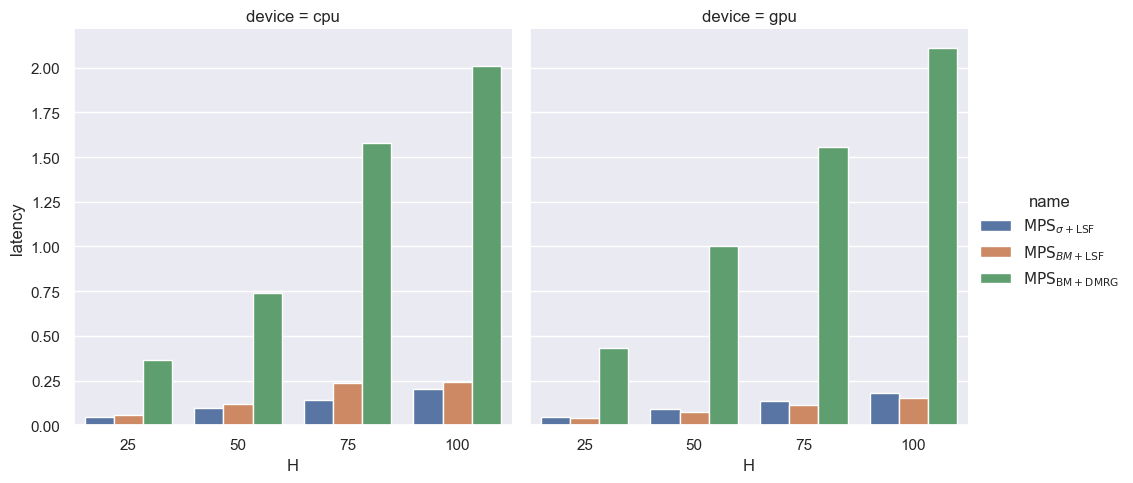

In [ ]:
# =====================================================================
# The `model` arg specifies the model/optimizer combination as follows:
#   - mps:      MPS$_\sigma$ with LSF optimizer
#   - bmnc:     MPS$_{BM}$ with LSF optimizer
#   - bm:       BM with DRMG optimizer
# =====================================================================

# Latency results:
# >> python scripts/profile_latency.py --horizons 25 50 75 100 --d_output 8 --models mps bm bmnc --device cpu --out results/latency_sweep_cpu.csv
# >> python scripts/profile_latency.py --horizons 25 50 75 100 --d_output 8 --models mps bm bmnc --device gpu --out results/latency_sweep_gpu.csv

df_cpu = pd.read_csv("../results/latency_sweep_cpu.csv")
df_gpu = pd.read_csv("../results/latency_sweep_gpu.csv")
df_cpu['device'] = 'cpu'
df_gpu['device'] = 'gpu'
df = pd.concat([df_cpu, df_gpu])

# Rename methods
df['name'] = df['name'].replace({
    'mps': r'$\mathrm{MPS}_{\sigma+\mathrm{LSF}}$',
    'bmnc': r'$\mathrm{MPS}_{BM+\mathrm{LSF}}$',
    'bm': r'$\mathrm{MPS}_{\mathrm{BM}+\mathrm{DMRG}}$'
})

sns.set_theme()
sns.catplot(
    data=df,
    x="H",
    y="latency",
    hue="name",
    col="device",
    kind="bar"
)


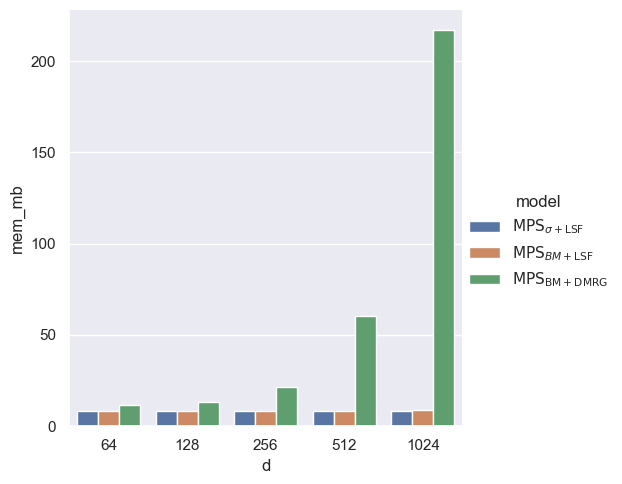

In [ ]:
# Memory results:
# >> python scripts/profile_memory.py --d_outputs 64 128 256 512 1024 --models mps bm bmnc

df_memory = pd.read_csv("../results/memory_sweep.csv")

# Rename methods
df_memory['model'] = df_memory['model'].replace({
    'mps': r'$\mathrm{MPS}_{\sigma+\mathrm{LSF}}$',
    'bmnc': r'$\mathrm{MPS}_{BM+\mathrm{LSF}}$',
    'bm': r'$\mathrm{MPS}_{\mathrm{BM}+\mathrm{DMRG}}$'
})

sns.set_theme()
sns.catplot(
    data=df_memory,
    x="d",
    y="mem_mb",
    hue="model",
    kind="bar"
)